In [15]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import copy 
import pandas as pd
import time
import datetime

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

# Data Preprocessing

In [16]:
    Dataset = r'15minute_data_newyork\15minute_data_newyork.csv'
    fulldata = pd.read_csv(Dataset) 

In [17]:
data=fulldata[['dataid','local_15min','grid']]

In [18]:
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])

In [19]:
ids=sorteddata['dataid'].unique().tolist()

In [20]:
housing_data = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for regession 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)

In [102]:
def create_dataset(dataset, look_back=1, look_ahead=look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-2*look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		if look_ahead == 0:
			dataY.append(dataset[i + look_back, 0])
		else:
			dataY.append(dataset[(i+look_back):(i+2*look_ahead), 0])
		
	return np.array(dataX), np.array(dataY)


In [192]:
#set up
dataframe = housing_data[0]['grid']
dataset = np.matrix(dataframe.values).transpose()
dataset = dataset.astype('float32')

In [193]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [194]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:,:]

In [195]:
# reshape into X=t and Y=t+look_back
look_back = 104
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [196]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [197]:
print(trainX.shape)
print(trainY.shape)

(11626, 104, 1)
(11626, 104)


In [152]:
trainY

array([[0.58250237, 0.58892775, 0.6010075 , ..., 0.58568937, 0.58126867,
        0.5881053 ],
       [0.58892775, 0.6010075 , 0.6061479 , ..., 0.58126867, 0.5881053 ,
        0.59057266],
       [0.6010075 , 0.6061479 , 0.6285597 , ..., 0.5881053 , 0.59057266,
        0.5846613 ],
       ...,
       [0.5788527 , 0.58270794, 0.58116585, ..., 0.59792334, 0.59823173,
        0.60105896],
       [0.58270794, 0.58116585, 0.5809603 , ..., 0.59823173, 0.60105896,
        0.6184847 ],
       [0.58116585, 0.5809603 , 0.5883109 , ..., 0.60105896, 0.6184847 ,
        0.5991056 ]], dtype=float32)

# LSTM

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [198]:
# create and fit the LSTM network
opm = 'adam'
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(104))
model.compile(loss='mean_squared_error', optimizer=opm)
model.fit(trainX, trainY, epochs=60, batch_size=1, verbose=2, use_multiprocessing=True)

Epoch 1/60
 - 802s - loss: 0.0250
Epoch 2/60
 - 841s - loss: 0.0130
Epoch 3/60
 - 842s - loss: 0.0118
Epoch 4/60
 - 842s - loss: 0.0114
Epoch 5/60
 - 845s - loss: 0.0108
Epoch 6/60
 - 788s - loss: 0.0106
Epoch 7/60
 - 774s - loss: 0.0105
Epoch 8/60
 - 771s - loss: 0.0105
Epoch 9/60
 - 770s - loss: 0.0104
Epoch 10/60
 - 773s - loss: 0.0104
Epoch 11/60
 - 767s - loss: 0.0104
Epoch 12/60
 - 773s - loss: 0.0103
Epoch 13/60
 - 767s - loss: 0.0103
Epoch 14/60
 - 770s - loss: 0.0103
Epoch 15/60
 - 770s - loss: 0.0103
Epoch 16/60
 - 764s - loss: 0.0103
Epoch 17/60
 - 768s - loss: 0.0102
Epoch 18/60
 - 764s - loss: 0.0102
Epoch 19/60
 - 771s - loss: 0.0102
Epoch 20/60
 - 762s - loss: 0.0102
Epoch 21/60
 - 770s - loss: 0.0102
Epoch 22/60
 - 771s - loss: 0.0102
Epoch 23/60
 - 768s - loss: 0.0102
Epoch 24/60
 - 772s - loss: 0.0101
Epoch 25/60
 - 765s - loss: 0.0101
Epoch 26/60
 - 770s - loss: 0.0101
Epoch 27/60
 - 769s - loss: 0.0101
Epoch 28/60
 - 774s - loss: 0.0101
Epoch 29/60
 - 771s - loss: 0

In [199]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [200]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [201]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.23 RMSE
Test Score: 2.29 RMSE


In [202]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.95 RMSE
Test Score: 2.40 RMSE


In [204]:
#save or load
testscore = ('%.2f' % (testScore)).replace('.', '_')
model.save(f'models/D_0house_model_{testscore}_{opm}.h5')
# model = load_model('0house_model.h5')

In [59]:
# shift train predictions for plotting
trainPredictPlot = np.empty([dataset.shape[0], trainPredict.shape[1]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [68]:
# shift test predictions for plotting
testPredictPlot = np.empty([dataset.shape[0], testPredict.shape[1]])
# testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*4):len(dataset), :] = testPredict

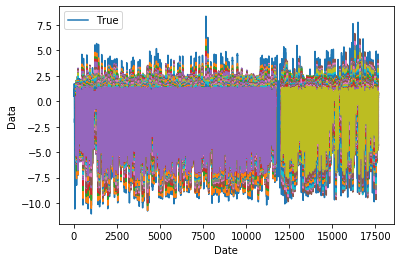

In [78]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label= 'True' )
plt.plot(trainPredictPlot )
plt.plot(testPredictPlot )
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.show()


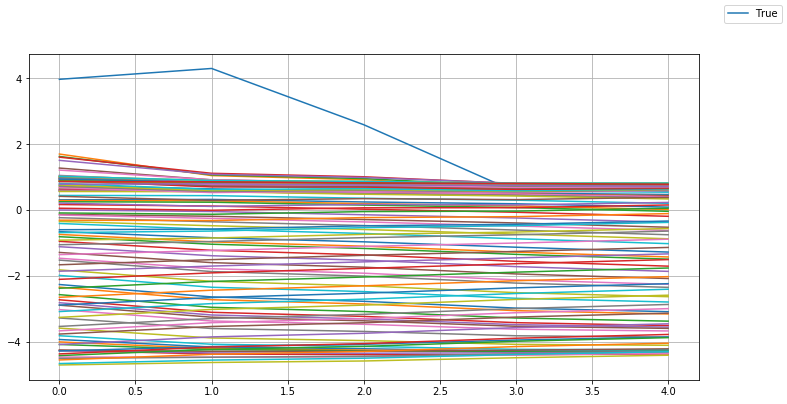

In [79]:
#check last values
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(scaler.inverse_transform(dataset)[-5:], label= 'True' )
# plt.plot(trainPredictPlot, label= 'train Predict')
ax.plot(testPredictPlot[-5:] )
ax.grid(True)
fig.legend()

# ax.show()

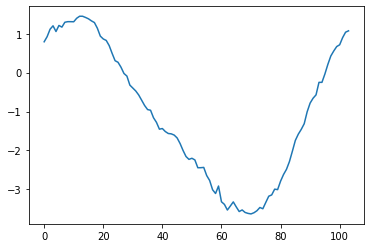

In [77]:
plt.plot(testPredictPlot[13043], label= 'test Predict')

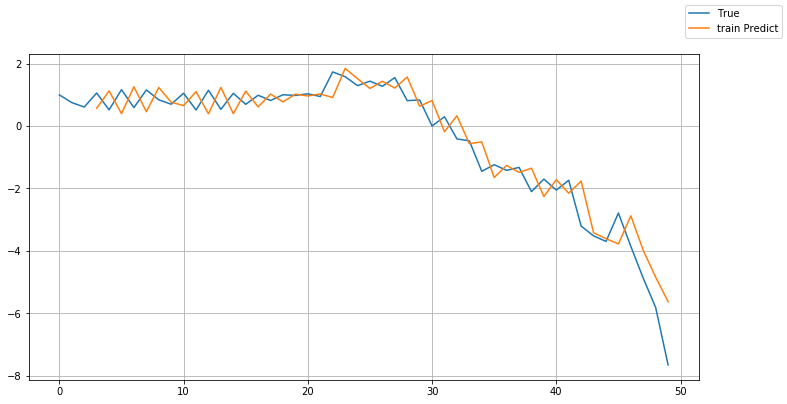

In [23]:
#check 1st values
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(scaler.inverse_transform(dataset)[:50], label= 'True' )
plt.plot(trainPredictPlot[:50], label= 'train Predict')
# ax.plot(testPredictPlot[:5], label= 'test Predict')
ax.grid(True)
fig.legend()


# Experiments 
## Performace on another House

In [24]:
#set up using house 1
dataframe1 = housing_data[1]['grid']
dataset1 = np.matrix(dataframe1.values).transpose()
dataset1 = dataset1.astype('float32')
dataset1 = scaler.fit_transform(dataset1)

In [25]:

#predict on new housing data
house1X, house1Y = create_dataset(dataset1, look_back)
house1X = house1X.reshape(house1X.shape[0], house1X.shape[1],1)
house1Predict = model.predict(house1X)

house1Predict = scaler.inverse_transform(house1Predict)
house1Y = scaler.inverse_transform([house1Y])



In [26]:
#score, closest to 0 the better
train1Score = math.sqrt(mean_squared_error(house1Y[0], house1Predict[:,0]))
print('Train Score: %.2f RMSE' % (train1Score))

Train Score: 0.43 RMSE


In [27]:
#plot set
house1PredictPlot = np.empty_like(dataset1)
house1PredictPlot[:, :] = np.nan
house1PredictPlot[look_back:len(house1Predict)+look_back, :] = house1Predict

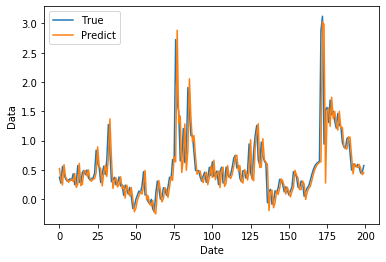

In [28]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset1)[-200:], label= 'True' )
plt.plot(house1PredictPlot[-200:], label= 'Predict')
# plt.plot(testPredictPlot, label= 'test Predict')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.show()


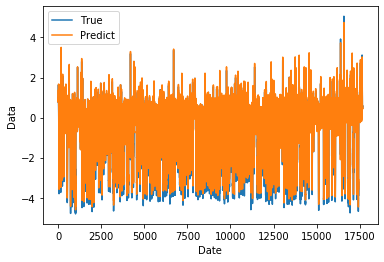

In [29]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset1), label= 'True' )
plt.plot(house1PredictPlot, label= 'Predict')
# plt.plot(testPredictPlot, label= 'test Predict')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.show()

In [ ]:
dataframe10 = housing_data[1]